In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pathlib

sys.path.append(str(pathlib.Path().cwd().parent))

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Reshape
from load_dataset import Dataset
from plotting import plot_ts

In [5]:
# извлекаем лаг сезонности
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

def extract_season_lag(data: pd.Series, granularity) -> int:
    season=granularity[-1:]

    data_per_day = pd.Series({'value':np.NaN}, index=pd.date_range(
                                start=data[:1].index.values[0],
                                end=data[-1:].index.values[0],
                                freq=season+'S' if season=='M' else season))
    data = data.groupby(data.index).first() #убираем дубликаты
    data = data_per_day.combine_first(data) #соединяем 
    data.index = pd.DatetimeIndex(data.index).to_period(season)
    data.fillna(method='pad', inplace=True) #заполняем NaN предыдущими значениями
    data.index=data.index.to_timestamp()

    result = seasonal_decompose(data, model = 'additive')

    data = np.diff((acf(result.seasonal)))
    extrem = []
    period = []
    extrem_flag=True
    for n in range(len(data)): #ищем экстремум функции
        if data[n]<0 and extrem_flag:
            extrem.append(data[n])
            extrem_flag=False
        if data[n]>0 and not extrem_flag: extrem_flag=True

    for n in extrem:
        period = np.append(period, np.where(data == n)[0][0])
        
    return int(period[1]) #берем первый лаг (нулевой пропускаем)

### Пример. Использование полносвязной сети в классической постановке задачи прогнозирования одномерного ряда (n лагов в качестве признаков, 1 лаг в качестве ответа).

In [ ]:
ts=pd.read_csv('..\\sbrf.csv', index_col='TRADEDATE', parse_dates=True)['CLOSE']

#### Возьмем уже известный ряд international-airline-passengers.csv

In [ ]:
dataset = Dataset('../data/dataset/')

In [ ]:
ts = dataset['international-airline-passengers.csv']

In [ ]:
ts.plot()

#### Зададим количество лагов и разобъем на train и test.

In [ ]:
extract_season_lag(ts, '1D')

In [ ]:
num_lags = 7

In [ ]:
len_train = int(len(ts)*0.8) #20% test
ts_train, ts_test = ts[:len_train], ts[len_train:]

#### Возьмем нашу функцию для перехода к supervised задаче с одной точкой в качестве ответа

In [ ]:
from typing import Tuple
def transform_into_matrix(ts: pd.Series, num_lags: int) -> Tuple[np.array]:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [ ]:
X_train, y_train = transform_into_matrix(ts_train, num_lags)

In [ ]:
X_test, y_test = transform_into_matrix(ts_test, num_lags)

#### Зададим однослойную сеть с 64 нейронами на входном слое, и размерностью, равной количество лагов.

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=num_lags))

#### Зададим выходной слой с одним нейроном

In [ ]:
model.add(Dense(1))

#### Скомпилируем и обучим сетку.

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(X_train, y_train, epochs=2000, verbose=0)

In [ ]:
ts.shape, X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

#### Получим one-step-ahead прогноз на тест

In [ ]:
y_pred_one_step = model.predict(X_test)

In [ ]:
plot_ts(ts_train, ts_test, pd.Series(y_pred_one_step.squeeze(), index=ts_test.index[num_lags:]), legends=['train', 'test', 'pred'])

#### Мы видим достаточно неплохое качество прогноза, однако каких-то качественных улучшений по сравнению с линейной регрессией, запущенной из коробки мы не видим.

In [ ]:
from model import TimeSeriesPredictor

predictor = TimeSeriesPredictor(granularity='P1D', num_lags=7)

In [ ]:
predictor.fit(ts_train)

In [ ]:
preds = predictor.predict_batch(ts_train, ts_test)

In [ ]:
plot_ts(ts, preds)

#### Тем не менее, в плане out-of-sample прогноза, запущенная из коробки lr показывает беду

In [ ]:
preds_out_of_sample = predictor.predict_next(ts_train, len(ts_test))

In [ ]:
plot_ts(ts, preds_out_of_sample)

## Решение - попробуем сформировать датасет так, чтобы учиться предсказать сразу 12 точек! Для этого как раз удобно использовать полносвязную сеть.

### Задание 1. Использование полносвязной сети для предсказания следующих 12 точек

### Задача - по предыдущем n точкам научиться предсказывать следующие m точек

In [ ]:
ts = dataset['alcohol_sales.csv']

D:\Anaconda3\envs\ts_summer\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


<AxesSubplot:xlabel='TRADEDATE'>

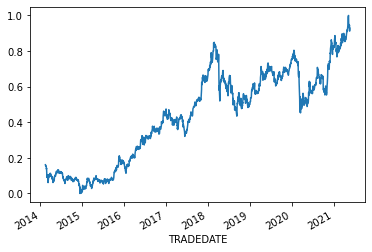

In [8]:
ts = pd.read_csv('..\\sbrf.csv', index_col='TRADEDATE', parse_dates=True)
ts = add_stock(ts)
ts['close'].plot()

### 1) Реализовать функцию разбиения одномерного ряда на входные данные для сетки

* принимает на вход ряд, количество входных и выходных лагов
* функция должна пройтись скользящим оконом ширины num_lags_in по временному ряду и для каждой итерации получить в качестве ответов следующие num_lags_out количество лагов
* каждый раз окно сдвигается на 1 лаг
* возращает два np.array X, y

In [11]:
from typing import Tuple

def my_transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    # your code here
    ts_values = ts.values
    data_x = []
    data_y = []
    for i in range(len(ts_values)-num_lags_out-num_lags_in+1):
        data_x.append(ts_values[i:num_lags_in+i])
        data_y.append(ts_values[num_lags_in+i:num_lags_in+i+num_lags_out])
    return np.array(data_x), np.array(data_y)

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    ts_values = ts.values
    data_x = []
    data_y = []
    i=0
    outer_idx=num_lags_out
    while outer_idx < len(ts_values):
        inner_idx=i+num_lags_in
        outer_idx=inner_idx+num_lags_out
        X_, y_ = ts_values[i:inner_idx], ts_values[inner_idx:outer_idx]
        data_x.append(X_)
        data_y.append(y_)
        i+=1
    return np.array(data_x), np.array(data_y)

#### 2) Разбить на трейн и тест, отложив в качестве теста последние 12 точек (обратите внимание, что в таком случае в  качестве X_test и y_test у вас будет всего один объект)

In [12]:
# ваш код здесь
num_lags = 180
num_output = 12
X, y = transform_ts_into_matrix(ts, num_lags, num_output)

In [13]:
X.shape, y.shape

((1644, 180, 19), (1644, 12, 19))

In [14]:
n_dims = 1 if type(ts) == pd.Series else len(ts.columns)
X.resize(len(X),num_lags*n_dims)
y.resize(len(y),num_output*n_dims)

In [15]:
X.shape, y.shape #((248, 60), (248, 12))

((1644, 3420), (1644, 228))

In [16]:
len_train = int(len(ts)*0.8) #20% test
X_train, y_train = X[:len_train], y[:len_train]
X_test, y_test = X[len_train:], y[len_train:]   

In [17]:
ts.shape, X_train.shape, y_train.shape #((319,), (248, 60), (248, 12))

((1835, 19), (1468, 3420), (1468, 228))

In [18]:
X_test.shape, y_test.shape #((1, 60), (12,))

((176, 3420), (176, 228))

In [19]:
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[[-1]], y[-1]

#### 3) Построить полносвязную сеть, указав нужное количество входных и выходных слоев

* в качестве архитектуры возьмите популярную конфигурацию слоев с 64 и 32 нейронами
* на первом слое необходимо указать входную размерность, равную количеству лагов на входе
* на выходном слое необхдимо указать количество нейронов, равное количеству выходных лагов
* activation, optimizer, loss можете выбрать сами, по умолчанию 'relu', 'adam', 'mse'

In [20]:
# ваш код здесь
n_dims = 1 if type(ts) == pd.Series else len(ts.columns)
shape_in= (num_lags*n_dims,) if type(ts) == pd.Series else (num_lags, n_dims)
model = Sequential()
model.add(Input(shape=(num_lags*n_dims,)))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(num_output*n_dims))
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                218944    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 228)               7524      
Total params: 228,548
Trainable params: 228,548
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.input_shape, model.output_shape

((None, 3420), (None, 228))

#### 4) Обучить сеть.

In [23]:
model.fit(X_train, y_train, epochs=2000, verbose=0)
#ваш код здесь

#### 5) Сделайте предикт на тесте и сравните результат с предыдущим подходом

In [24]:
# ваш код здесь
y_pred = model.predict(X_test)

In [25]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score

from metrics import mean_absolute_percentage_error as mape
from metrics import mase

In [26]:
def calculate_metrics(test, in_sample, out_of_sample=0):
        metrics={   'mse':{'in':0, 'out':0},
                    'mae':{'in':0, 'out':0},
                    'r2_score':{'in':0, 'out':0},
                    'mape':{'in':0, 'out':0},
                    'mase':{'in':0, 'out':0}}

        metrics['mse']['in'] = MSE(test, in_sample)
        metrics['mae']['in'] = MAE(test, in_sample)
        metrics['r2_score']['in'] = r2_score(test, in_sample)
        metrics['mape']['in'] = mape(test, in_sample) 
        metrics['mase']['in'] = mase(in_sample, test)
        if out_of_sample:
            metrics['mse']['out'] = MSE(test, out_of_sample)
            metrics['mae']['out'] = MAE(test, out_of_sample)
            metrics['r2_score']['out'] = r2_score(test, out_of_sample)
            metrics['mape']['out'] = mape(test, out_of_sample)
            metrics['mase']['out'] = mase(out_of_sample, test)

        return metrics

In [27]:
calculate_metrics(pd.Series(y_test.flatten()), pd.Series(y_pred.flatten()))

{'mse': {'in': 0.024488519111359266, 'out': 0},
 'mae': {'in': 0.0716373498355879, 'out': 0},
 'r2_score': {'in': 0.48342686193436346, 'out': 0},
 'mape': {'in': inf, 'out': 0},
 'mase': {'in': 0.5217653328994383, 'out': 0}}

In [28]:
#365/7
{'mse': {'in': 0.02756688321290948, 'out': 0},
 'mae': {'in': 0.08072336750279668, 'out': 0},
 'r2_score': {'in': 0.5164549712999624, 'out': 0},
 'mape': {'in': inf, 'out': 0},
 'mase': {'in': 0.4980154429446579, 'out': 0}}

NameError: name 'inf' is not defined

In [ ]:
#180/7
{'mse': {'in': 0.018192904180652718, 'out': 0},
 'mae': {'in': 0.05574542503679411, 'out': 0},
 'r2_score': {'in': 0.6808820095392175, 'out': 0},
 'mape': {'in': inf, 'out': 0},
 'mase': {'in': 0.3439163082595063, 'out': 0}}

In [ ]:
#180/21
{'mse': {'in': 0.02170433819128017, 'out': 0},
 'mae': {'in': 0.0726612222985002, 'out': 0},
 'r2_score': {'in': 0.3829234114528405, 'out': 0},
 'mape': {'in': inf, 'out': 0},
 'mase': {'in': 0.6156744992933951, 'out': 0}}

In [ ]:
#365/21
{'mse': {'in': 0.022049790477917337, 'out': 0},
 'mae': {'in': 0.09791020367738065, 'out': 0},
 'r2_score': {'in': 0.3731018487465645, 'out': 0},
 'mape': {'in': inf, 'out': 0},
 'mase': {'in': 0.8296146654008315, 'out': 0}}

In [ ]:
#365/12
{'mse': {'in': 0.024547237768327287, 'out': 0},
 'mae': {'in': 0.08306810064746385, 'out': 0},
 'r2_score': {'in': 0.48218822105309844, 'out': 0},
 'mape': {'in': inf, 'out': 0},
 'mase': {'in': 0.6050203600094183, 'out': 0}}

In [ ]:
#180/5
{'mse': {'in': 0.014413118953160942, 'out': 0},
 'mae': {'in': 0.041831355240371675, 'out': 0},
 'r2_score': {'in': 0.7620175400448727, 'out': 0},
 'mape': {'in': inf, 'out': 0},
 'mase': {'in': 0.2454167853008269, 'out': 0}}

In [ ]:
#180/12
{'mse': {'in': 0.0012944125289113325, 'out': 0},
 'mae': {'in': 0.03405162682049854, 'out': 0},
 'r2_score': {'in': -0.7455297940633048, 'out': 0},
 'mape': {'in': 3.6169427278972197, 'out': 0},
 'mase': {'in': 2.0049544107382014, 'out': 0}}

In [ ]:
#60/12
{'mse': {'in': 0.015051777990708538, 'out': 0},
 'mae': {'in': 0.052888787337822964, 'out': 0},
 'r2_score': {'in': 0.6824902251226408, 'out': 0},
 'mape': {'in': inf, 'out': 0},
 'mase': {'in': 0.3852115662472194, 'out': 0}}

In [32]:
if n_dims >1:
    y_test.resize(1,num_output,n_dims)
    y_pred.resize(1,num_output,n_dims)

In [34]:
if n_dims >1:
    plot_ts(pd.Series(y_test[0][:,0], index=ts.index[-num_output:]), pd.Series(y_pred[0][:,0], index=ts.index[-num_output:]), ts.iloc[:,0][:], legends=['test', 'pred', 'TS'])
else:
    plot_ts(pd.Series(y_test, index=ts.index[-num_output:]), pd.Series(y_pred.flatten(), index=ts.index[-num_output:]), ts[-num_output:], legends=['test', 'pred', 'TS'])

Loading BokehJS ...

In [35]:
#проверяем результат прогноза по всему ряду
pred_batch=np.array([])
for n in range(0,len(X),num_output):
    pred = model.predict(X[[n]])
    pred.resize(1,num_output,n_dims)
    pred_batch = np.append(pred_batch, pred[0][:,0])
plot_ts(pd.Series(pred_batch, index=ts.index[num_lags:-num_output+1]), ts.iloc[:,0][:], legends=['pred', 'TS'])    

Loading BokehJS ...

In [458]:
#проверяем результат прогноза по всему ряду как в жизни (с подгрузкой новых данных)
for i in range(len(ts)-num_lags-num_output):
    X, y = transform_ts_into_matrix(ts[i:num_lags+num_output+i], num_lags, num_output)


In [460]:
X.shape

(1, 180, 19)

### Использование полносвязной сети для предсказания многомерного ряда

In [ ]:
ts = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

In [ ]:
ts.plot(figsize=(20, 10))

In [ ]:
ts.fillna(ts.median(), inplace=True)

#### 1) Реализовать функцию, которая разбивает исходный ряд на входные данные X и y для сетки

In [ ]:
def transform_multi_ts_into_matrix(ts: pd.DataFrame, num_lags: int):
    """
    Данная функция должна пройтись скользящим окном по временному ряду
    и собрать в качестве признаков X np.array размерности (len(ts)-num_lags, n_dims, num_lags),
    а в качестве y np.array размерности (len(ts)-num_lags, n_dims),
    где n_dims - размерность многомерного ряда.
    
    То есть для всех компонент временного ряда мы должны взять num_lags предыдущих точек каждой компонент
    в качестве признаков и все компоненты текущей точки в качестве target
    """
    # your code here
    ts = ts.values
    X,y = [],[]
    for i in range (len(ts)-num_lags):
        X.append(ts[i:num_lags+i].T.flatten())
        y.append(ts[num_lags+i:num_lags+i+1])

    X = np.array(X)
    y = np.array(y).squeeze()
    return X, y

In [7]:
from stock_pandas import StockDataFrame
from sklearn.preprocessing import MinMaxScaler
def add_stock(data: pd.DataFrame):
    data.rename(columns={'CLOSE':'close'}, inplace=True)
    data['difference'] = data['close'] - data['close'].shift(1)
    data['up_down'] = data['difference'].apply(lambda x: 1 if x >= 0 else 0) #1 рост цены, 0 падение цены
    data = data.drop(columns=['difference', 'VALUE', 'VOLUME'])

    stock = StockDataFrame(data)    
    stock.exec('ma:5', create_column=True)
    stock.exec('ma:10', create_column=True)
    stock.exec('ma:30', create_column=True)
    stock.exec('ema:5', create_column=True)
    stock.exec('ema:10', create_column=True)
    stock.exec('ema:30', create_column=True)
    stock.exec('rsi:5', create_column=True)
    stock.exec('rsi:10', create_column=True)
    stock.exec('rsi:30', create_column=True)
    stock.exec('boll', create_column=True)
    stock.exec('macd', create_column=True)
    stock.exec('bbi', create_column=True)    
    data=data.dropna()
    data.fillna(data.median(), inplace=True)
    scaler = MinMaxScaler(feature_range=(0,1))
    data = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)
    return data


In [ ]:
ts = pd.read_csv('..\\sbrf.csv', index_col='TRADEDATE', parse_dates=True)
ts = add_stock(ts)

In [ ]:
n_lags = 24

In [ ]:
X, y = transform_multi_ts_into_matrix(ts, n_lags)

In [ ]:
X.shape, y.shape

In [ ]:
ts.head()

#### 2) Разбить на трейн и тест

In [ ]:
# ваш код здесь
len_train = int(len(X)*0.8) #20% test
x_train, y_train = X[:len_train], y[:len_train]
x_test, y_test = X[len_train:], y[len_train:]

In [ ]:
x_train.shape, y_train.shape

#### 3) Построить полносвязную сеть, указав нужное количество входных и выходных слоев

In [ ]:
# ваш код здесь
n_dims = len(ts.columns)
model = Sequential()
model.add(Dense(64, activation="relu", input_dim=(n_dims*n_lags)))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dense(n_dims))
model.compile(optimizer='adam', loss='mse')

####  4) Обучить модель 

In [ ]:
# ваш код здесь
model.fit(x_train, y_train, epochs=2000, verbose=0)

#### 5) Сделайте прогноз

In [ ]:
# ваш код здесь
y_pred = model.predict(x_test)

In [ ]:
df_metrics = pd.DataFrame(columns=['column_name', 'mse', 'mae', 'r2_score', 'mape', 'mase'])
for n_columns in range(n_dims):
    metric = calculate_metrics(ts.iloc[:,n_columns][-len(y_pred):], pd.Series(y_pred[:,n_columns], index=ts.index[-len(y_pred):]))
    metric.update({'column_name':{'in':f'{ts.columns[n_columns]}-column:{n_columns}'}})
    df_metrics=df_metrics.append(pd.DataFrame(metric))
df_metrics = df_metrics[df_metrics.index == 'in']

In [ ]:
df_metrics.sort_values(['mse', 'mae', 'r2_score', 'mape', 'mase'])

In [ ]:
n_columns=10
plot_ts(
        ts.iloc[:,n_columns],
        pd.Series(y_pred[:,n_columns], index=ts.index[-len(y_pred):]),
        legends=[ts.columns[n_columns], 'pred']);        